In [1]:
import gym 
import numpy as np
import sys 
import torch
import torch.nn as nn
import torch.optim

from torch.autograd import Variable
import copy
import torchvision.transforms as T
import random
import time

## Environment Creation

In [2]:
import collections
env = gym.make('CartPole-v1')

In [3]:
## Printing the environment action space 
print( env.observation_space)
print( env.action_space )

Box(4,)
Discrete(2)


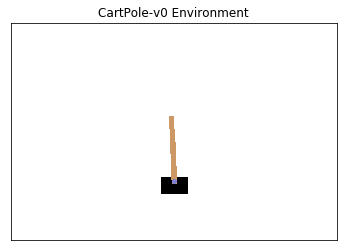

In [4]:
# Demonstration
from IPython.display import clear_output
import matplotlib.pyplot as plt

def get_screen():
    ''' Extract one step of the simulation.'''
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    return torch.from_numpy(screen)

# Speify the number of simulation steps
num_steps = 2

# Show several steps
for i in range(num_steps):
    clear_output(wait=True)
    env.reset()
    plt.figure()
    plt.imshow(get_screen().cpu().permute(1, 2, 0).numpy(),
               interpolation='none')
    plt.title('CartPole-v0 Environment')
    plt.xticks([])
    plt.yticks([])
    plt.show()
env.close()

## Creating the class for  ICM Module for the agent 

Defining the required models:
- Inverse Model - This predicts action given feature representation on current and next state
- Forward Model - This predicts features of next state given action and features of current state
- Feature Extractor - This is used in the Inverse Model for learning features of a given state


In [5]:
class InverseModel(nn.Module):
    def __init__(self, n_actions, hidden_dims):
        super(InverseModel, self).__init__()
        self.fc = nn.Linear(hidden_dims*2, n_actions)
        
    def forward(self, features):
        features = features.view(1, -1) # (1, hidden_dims)
        action = self.fc(features) # (1, n_actions)
        return action

class ForwardModel(nn.Module):
    def __init__(self, n_actions, hidden_dims):
        super(ForwardModel, self).__init__()
        self.fc = nn.Linear(hidden_dims+n_actions, hidden_dims)
        self.eye = torch.eye(n_actions)
        
    def forward(self, action, features):
        x = torch.cat([self.eye[action], features], dim=-1) # (1, n_actions+hidden_dims)
        features = self.fc(x) # (1, hidden_dims)
        return features

class FeatureExtractor(nn.Module):
    def __init__(self, space_dims, hidden_dims):
        super(FeatureExtractor, self).__init__()
        self.fc = nn.Linear(space_dims, hidden_dims)
        
    def forward(self, x):
        y = torch.tanh(self.fc(x))
        return y

## The ICM Module

This represents the forward and inverse models. This also contains the functions for computation of icm loss 
as a weighted combination of forward and inverse model losses. 

In [6]:
class ICMmodule():
    def __init__(self, n_actions, n_states, args):
        self.feature_extractor = FeatureExtractor(n_states, 32)
        self.forward_model = ForwardModel(n_actions, 32)
        self.inverse_model = InverseModel(n_actions, 32)
        self.icm_params = list(self.feature_extractor.parameters()) + list(self.forward_model.parameters()) + list(self.inverse_model.parameters())
        self.icm_optim = torch.optim.Adam(self.icm_params, lr=args.lr_icm)
        self.beta = args.beta
        self.eta = args.eta
        self.mse_loss = nn.MSELoss()
        self.xe_loss = nn.CrossEntropyLoss()
        
    def zero_grad(self):
        self.icm_optim.zero_grad()
        
    def backward(self):
        self.icm_optim.backward()
        
    def computeLoss( self, obs_cat, action):
        t_action = to_tensor(action)
        features = self.feature_extractor(obs_cat) # (2, hidden_dims)
        inverse_action_prob = self.inverse_model(features) # (n_actions)
        est_next_features = self.forward_model(t_action, features[0:1])

        # Loss - ICM
        forward_loss = self.mse_loss(est_next_features, features[1].unsqueeze(0))
        inverse_loss = self.xe_loss(inverse_action_prob, t_action.view(-1))
        icm_loss = (1-self.beta)*inverse_loss + self.beta*forward_loss
        intrinsic_reward = args.eta*forward_loss.detach()
        
        return icm_loss, intrinsic_reward

        

## Defining models for Actor and Critic

In [7]:
class ActorModel(nn.Module):
    def __init__(self, n_actions, space_dims, hidden_dims):
        super(ActorModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(space_dims, hidden_dims),
            nn.ReLU(True),
        )
        self.actor = nn.Sequential(
            nn.Linear(hidden_dims, n_actions),
            nn.Softmax(dim=-1),
        )
    
    def forward(self, x):
        features = self.feature_extractor(x)
        policy = self.actor(features)
        return policy
    
class CriticModel(nn.Module):
    def __init__(self, space_dims, hidden_dims):
        super(CriticModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(space_dims, hidden_dims ),
            nn.ReLU(True),
        )
        self.critic = nn.Linear(hidden_dims, 1)
    
    def forward(self, x):
        features = self.feature_extractor(x)
        est_reward = self.critic(features)
        return est_reward

In [8]:
class PGLoss(nn.Module):
    def __init__(self):
        super(PGLoss, self).__init__()
    
    def forward(self, action_prob, reward):
        loss = -torch.mean(torch.log(action_prob+1e-6)*reward)
        return loss

In [9]:
def to_tensor(x, dtype=None):
    return torch.tensor(x, dtype=dtype).unsqueeze(0)

In [10]:
class ConfigArgs:
    beta = 0.2
    lamda = 0.1
    eta = 100.0 # scale factor for intrinsic reward
    discounted_factor = 0.99
    lr_critic = 0.005
    lr_actor = 0.001
    lr_icm = 0.001
    max_eps = 1000
    sparse_mode = True

args = ConfigArgs()

In [11]:
pg_loss = PGLoss()
mse_loss = nn.MSELoss()

In [12]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

## ICM with A2C 

Advantageous Actor Critic uses an actor loss and critic loss function which is supplied as input. 
The intrinsic reward symbolizing curiosity is evaluated using the ICM module. Finally the total loss, the icm 
loss and the policy gradient loss are updated simultaneously in every step. 

In [13]:
class ICMwithA2C():
    def __init__(self, env, args, actor_loss, critic_loss):
        self.icm_module = ICMmodule(env.action_space.n, env.observation_space.shape[0], args)
        self.actor = ActorModel(n_actions=env.action_space.n, space_dims=4, hidden_dims=32)
        self.critic = CriticModel(space_dims=4, hidden_dims=32)
        self.a_optim = torch.optim.Adam(self.actor.parameters(), lr=args.lr_actor)
        self.c_optim = torch.optim.Adam(self.critic.parameters(), lr=args.lr_critic)
        self.actor_loss = actor_loss
        self.critic_loss = critic_loss

    def select_action(self,policy):
        return np.random.choice(len(policy), 1, p=policy)[0]
    
    def gradientStep(self):
        self.icm_module.icm_optim.step()
        self.a_optim.step()
        self.c_optim.step()
        
    def grad(self):
        self.a_optim.zero_grad()
        self.c_optim.zero_grad()
        self.icm_module.zero_grad()
        
        
    def runEpisode(self):
        next_obs = to_tensor(env.reset(), dtype=torch.float)
        done = False
        score = 0
        ireward_lst = []
        total_agent_reward = 0
        steps = 0
        while not done  and steps < 200:
            obs = next_obs
            self.grad()
        
            # predict policy for current state using the actor
            policy = self.actor(obs)
            # select action using the policy 
            action = self.select_action(policy.detach().numpy()[0])
        
            # Take step with the environment
            next_obs, reward, done, info = env.step(action)
            next_obs = to_tensor(next_obs, dtype=torch.float)
            
            # Find the values of current state and next state using critic
            v = self.critic(obs)[0]
            next_v = self.critic(next_obs)[0]
            
            total_agent_reward += reward
            
            # ICM Loss  and Intrinsic Reward
            obs_cat = torch.cat([obs, next_obs], dim=0)
            icm_loss, intrinsic_reward = self.icm_module.computeLoss( obs_cat, action)
            
            # Compute the extrinsic reward
            extrinsic_reward = to_tensor([0.], dtype=torch.float) if args.sparse_mode else to_tensor([reward], \
                                                                        dtype=torch.float)
            t_action = to_tensor(action)
 

            # Compute advantage for A2C
            advantages = torch.zeros_like(policy)
            total_reward = extrinsic_reward + intrinsic_reward
            advantages[0, action] = total_reward + args.discounted_factor*next_v - v
            c_target = total_reward + args.discounted_factor*next_v
            
            # Handling the terminal state differently
            if done:
                total_reward = -100 + intrinsic_reward if score < 199 else intrinsic_reward
                advantages[0, action] = total_reward - v
                c_target = to_tensor(total_reward).unsqueeze(0)


            # Loss - Actor Critic
            actor_loss = self.actor_loss(policy, advantages.detach())
            critic_loss = self.critic_loss(v.unsqueeze(0), c_target.detach())
#             print( v.size(), c_target.detach().size(), v.unsqueeze(0).size())
            ac_loss = actor_loss + critic_loss
               
            # Update
            loss = args.lamda*ac_loss + icm_loss
            loss.backward()
            self.gradientStep()
        
            if not done:
                score += reward

            ireward_lst.append(intrinsic_reward.item())
            
            steps += 1
            
        total_intrinsic_reward = sum(ireward_lst)
        return total_intrinsic_reward, score, total_agent_reward
    
    
    def train(self):
        global_step = 0
        n_eps = 0
        reward_lst = []
        mva_lst = []
        mva = 0.
        avg_ireward_lst = []
        final_rewards =  []
        for episode in range(args.max_eps):
            avg_intrinsic_reward, score, extrinsic_reward = self.runEpisode()
            mva = 0.95*mva + 0.05*score
            reward_lst.append(score)
            avg_ireward_lst.append(avg_intrinsic_reward)
            mva_lst.append(mva)
            final_rewards.append( extrinsic_reward )
            plot_res(reward_lst, title='ICM')
        return reward_lst, avg_ireward_lst, mva_lst
            
            
#             print('Episodes: {}, AVG Score: {:.3f}, Score: {}, AVG reward i: {:.6f}'.format(episode,  \
#                                                                         mva, score, avg_intrinsic_reward))

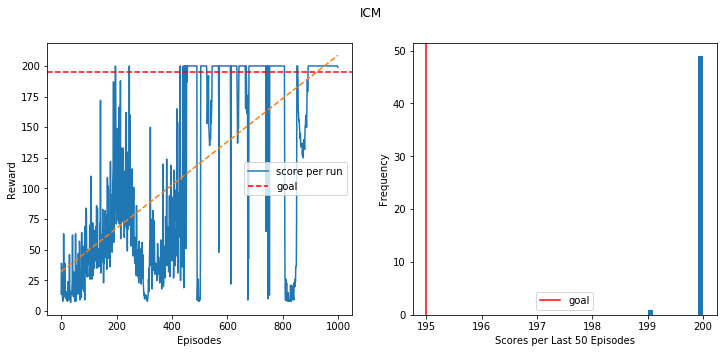

In [14]:
agent = ICMwithA2C(env=env,args=args, actor_loss=pg_loss, critic_loss=mse_loss)
reward_lst, avg_ireward_lst , mva_lst = agent.train()

In [15]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

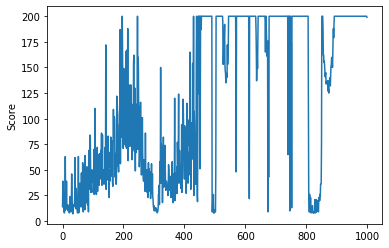

In [16]:
plt.plot(reward_lst)
plt.ylabel('Score')
plt.show()

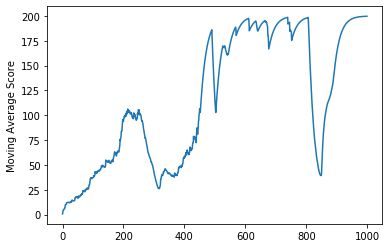

In [17]:
plt.plot(mva_lst)
plt.ylabel('Moving Average Score')
plt.show()

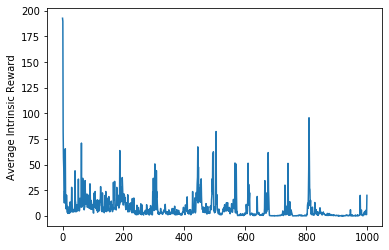

In [18]:
plt.plot(avg_ireward_lst)
plt.ylabel('Average Intrinsic Reward')
plt.show()

In [19]:
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, hidden_dim*2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim*2, action_dim)
                    )
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr)



    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

In [20]:
def q_learning(env, model, episodes, gamma=0.9, 
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=20, 
               title = 'DQL', double=False, 
               n_update=10, soft=False, verbose=True):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    episode_i=0
    sum_total_replay_time=0
    for episode in range(episodes):
        episode_i+=1
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset()
        done = False
        total = 0
        steps = 0
        while not done and steps < 200:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break

            if replay:
                t0=time.time()
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
                t1=time.time()
                sum_total_replay_time+=(t1-t0)
            else: 
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state
            steps += 1
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)
        
        if verbose:
            print("episode: {}, total reward: {}".format(episode_i, total))
            if replay:
                print("Average replay time:", sum_total_replay_time/episode_i)
        
    return final

In [24]:
# Number of states
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 500
# Number of hidden nodes in the DQN
n_hidden = 50
# Learning rate
lr = 0.001

In [25]:
class DQN_double(DQN):
    def __init__(self, state_dim, action_dim, hidden_dim, lr):
        super().__init__(state_dim, action_dim, hidden_dim, lr)
        self.target = copy.deepcopy(self.model)
        
    def target_predict(self, s):
        ''' Use target network to make predicitons.'''
        with torch.no_grad():
            return self.target(torch.Tensor(s))
        
    def target_update(self):
        ''' Update target network with the model weights.'''
        self.target.load_state_dict(self.model.state_dict())
        
    def replay(self, memory, size, gamma=1.0):
        ''' Add experience replay to the DQL network class.'''
        if len(memory) >= size:
            # Sample experiences from the agent's memory
            data = random.sample(memory, size)
            states = []
            targets = []
            # Extract datapoints from the data
            for state, action, next_state, reward, done in data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if done:
                    q_values[action] = reward
                else:
                    # The only difference between the simple replay is in this line
                    # It ensures that next q values are predicted with the target network.
                    q_values_next = self.target_predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                targets.append(q_values)

            self.update(states, targets)

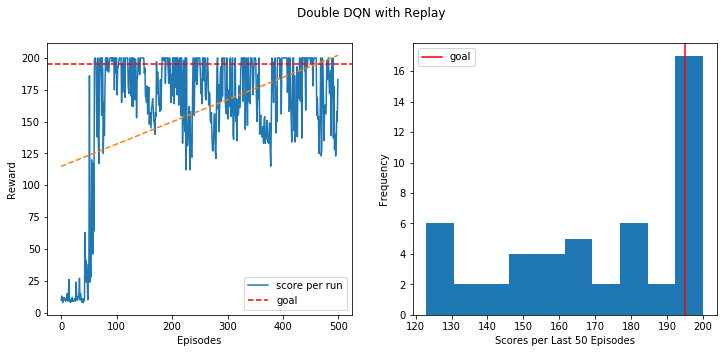

episode: 500, total reward: 183.0
Average replay time: 1.060520679950714


In [26]:
# Get replay results
dqn_double = DQN_double(n_state, n_action, n_hidden, lr)
double =  q_learning(env, dqn_double, episodes, gamma=.9, 
                    epsilon=0.2, replay=True, double=True,
                    title='Double DQN with Replay', n_update=10)